In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import copy
from torch.nn.modules import Module
from torch import Tensor
from torch import nn as nn
import math
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForPreTraining
from symbxai.model.transformer import bert_base_uncased_model
from symbxai.lrp.symbolic_xai import BERTSymbXAI
from symbxai.visualization.utils import rescale_score_by_abs, getRGB, html_heatmap, \
make_text_string, make_color

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats as st
from datasets import load_dataset
from itertools import product
import dgl
import networkx as nx

/home/farnoush/MyGiT/symbxai_cleaned_temporary/symbxai_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load BERT 

In [3]:
# load tokenizer
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

# Create model.
model = bert_base_uncased_model(
    pretrained_model_name_or_path='textattack/bert-base-uncased-SST-2'
)
model.eval()
pretrained_embeddings = model.bert.embeddings

/home/farnoush/MyGiT/symbxai_cleaned_temporary/symbxai_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Load SST dataset

In [4]:
from dgl.data import SSTDataset

mode =  'treebank' # 'treebank' 
if mode == 'huggingface':
    # Load SST2 dataset.
    dataset = load_dataset("sst2", "default")
if mode == 'treebank':
    dataset = SSTDataset(mode='train')
    vocab_words = list(dataset.vocab.keys())


In [5]:
def process_treeid2tokenid(indices, mask, tokens, lsent, verbose=False):
    assert len(mask.nonzero()) == len(lsent), f'len(mask.nonzero()) = {len(mask.nonzero())} != {len(lsent)} = len(indices) '
    cls_id = 0
    sep_id = len(tokens)-1
    
    wordInd2token = {}
    curr_tid = 1 # start with the first token
    for word_tid in range(len(lsent)):
        if tokens[curr_tid] == lsent[word_tid]: 
            wordInd2token[word_tid] = [curr_tid]
            curr_tid += 1
            continue
        else:
            word_string = tokens[curr_tid].replace('##', '')
            tids = [curr_tid]
            while word_string != lsent[word_tid]:
                curr_tid += 1
                word_string += tokens[curr_tid].replace('##', '')
                tids.append(curr_tid)
                if curr_tid == sep_id : 
                    raise RuntimeError(f'Not possible to parse {tokens} into {lsent}')
            
            wordInd2token[word_tid] = tids
            curr_tid += 1
        
    if verbose: print(wordInd2token)
        
    token_indices = []
    for ind in indices:
        word_ids = list(mask.nonzero().squeeze().numpy())
        if ind in word_ids:
            token_indices += wordInd2token[word_ids.index(ind)]
    
    return token_indices

### Plot a few data samples

In [6]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from symbxai.visualization.utils import make_color
import copy

label2sent_symb = {0:'--', 1: '-', 2:'0', 3: '+', 4:'++'}

In [7]:
def vis_tree_heat(tree, node_heat, vocab_words, node_labels=None, save_dir=None, word_dist=40, node_size=2000):
    fig, ax = plt.subplots(figsize=[12, 8], dpi=150)

    G = dgl.to_networkx(tree)
    G = G.to_undirected()
    pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
    pos = {int(k): v for k, v in pos.items()}
    print(pos)

    # nodes
    nx.draw_networkx_nodes(G,
                           pos,
                           node_color=node_heat,
                           edgecolors='black',
                           node_size=node_size,
                           ax=ax)

    # labels
    if node_labels is not None:
        nx.draw_networkx_labels(G, pos,
                                labels=node_labels,
                                font_size=10, ax=ax)

    # edges
    nx.draw_networkx_edges(G, pos, ax=ax)

    # words
    mask = tree.ndata['mask']
    leaf_nodes = mask.nonzero().squeeze().numpy()
    pos_ = copy.copy(pos)

    for ln in leaf_nodes: pos_[ln] = (pos_[ln][0], pos_[ln][1] - word_dist)

    input_ids = tree.ndata['x']
    nx.draw_networkx_labels(G, pos_,
                            labels={ln: vocab_words[idw] for ln, idw in zip(leaf_nodes, input_ids[mask == 1])},
                            font_size=10, ax=ax)

    
    ax.set_axis_off()
    plt.tight_layout()
    plt.margins(y=.1, x=.0)

    if save_dir is not None:
        plt.savefig(save_dir, transparent=True)
        
    plt.show()

#### Plot ground truth

In [8]:
# sid = 5004
sid = 7
tree = dataset[sid]
input_ids = tree.ndata['x'] # word id of the node
labels = tree.ndata['y'] #  label of the node
mask = tree.ndata['mask']
lsent =  [vocab_words[idw] for idw in input_ids[mask == 1]]
sentence =  make_text_string(lsent)
sample = tokenizer(sentence, return_tensors="pt")
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    


node_labels = {i:label2sent_symb[int(label)] for i,label in enumerate(labels)}

node_heat = [make_color( (float(label) - 2.)/3.) for label in labels]

{0: (185.0, 666.0), 1: (149.0, 594.0), 2: (77.0, 522.0), 3: (149.0, 522.0), 4: (77.0, 450.0), 5: (149.0, 450.0), 6: (99.0, 378.0), 7: (27.0, 306.0), 8: (99.0, 306.0), 9: (171.0, 378.0), 10: (171.0, 306.0), 11: (243.0, 306.0), 12: (189.0, 234.0), 13: (261.0, 234.0), 14: (221.0, 594.0), 15: (221.0, 522.0), 16: (221.0, 450.0), 17: (293.0, 450.0), 18: (270.0, 378.0), 19: (342.0, 378.0), 20: (329.0, 306.0), 21: (401.0, 306.0), 22: (369.0, 234.0), 23: (297.0, 162.0), 24: (369.0, 162.0), 25: (333.0, 90.0), 26: (405.0, 90.0), 27: (441.0, 234.0), 28: (441.0, 162.0), 29: (513.0, 162.0), 30: (495.0, 90.0), 31: (459.0, 18.0), 32: (531.0, 18.0), 33: (567.0, 90.0), 34: (293.0, 522.0)}


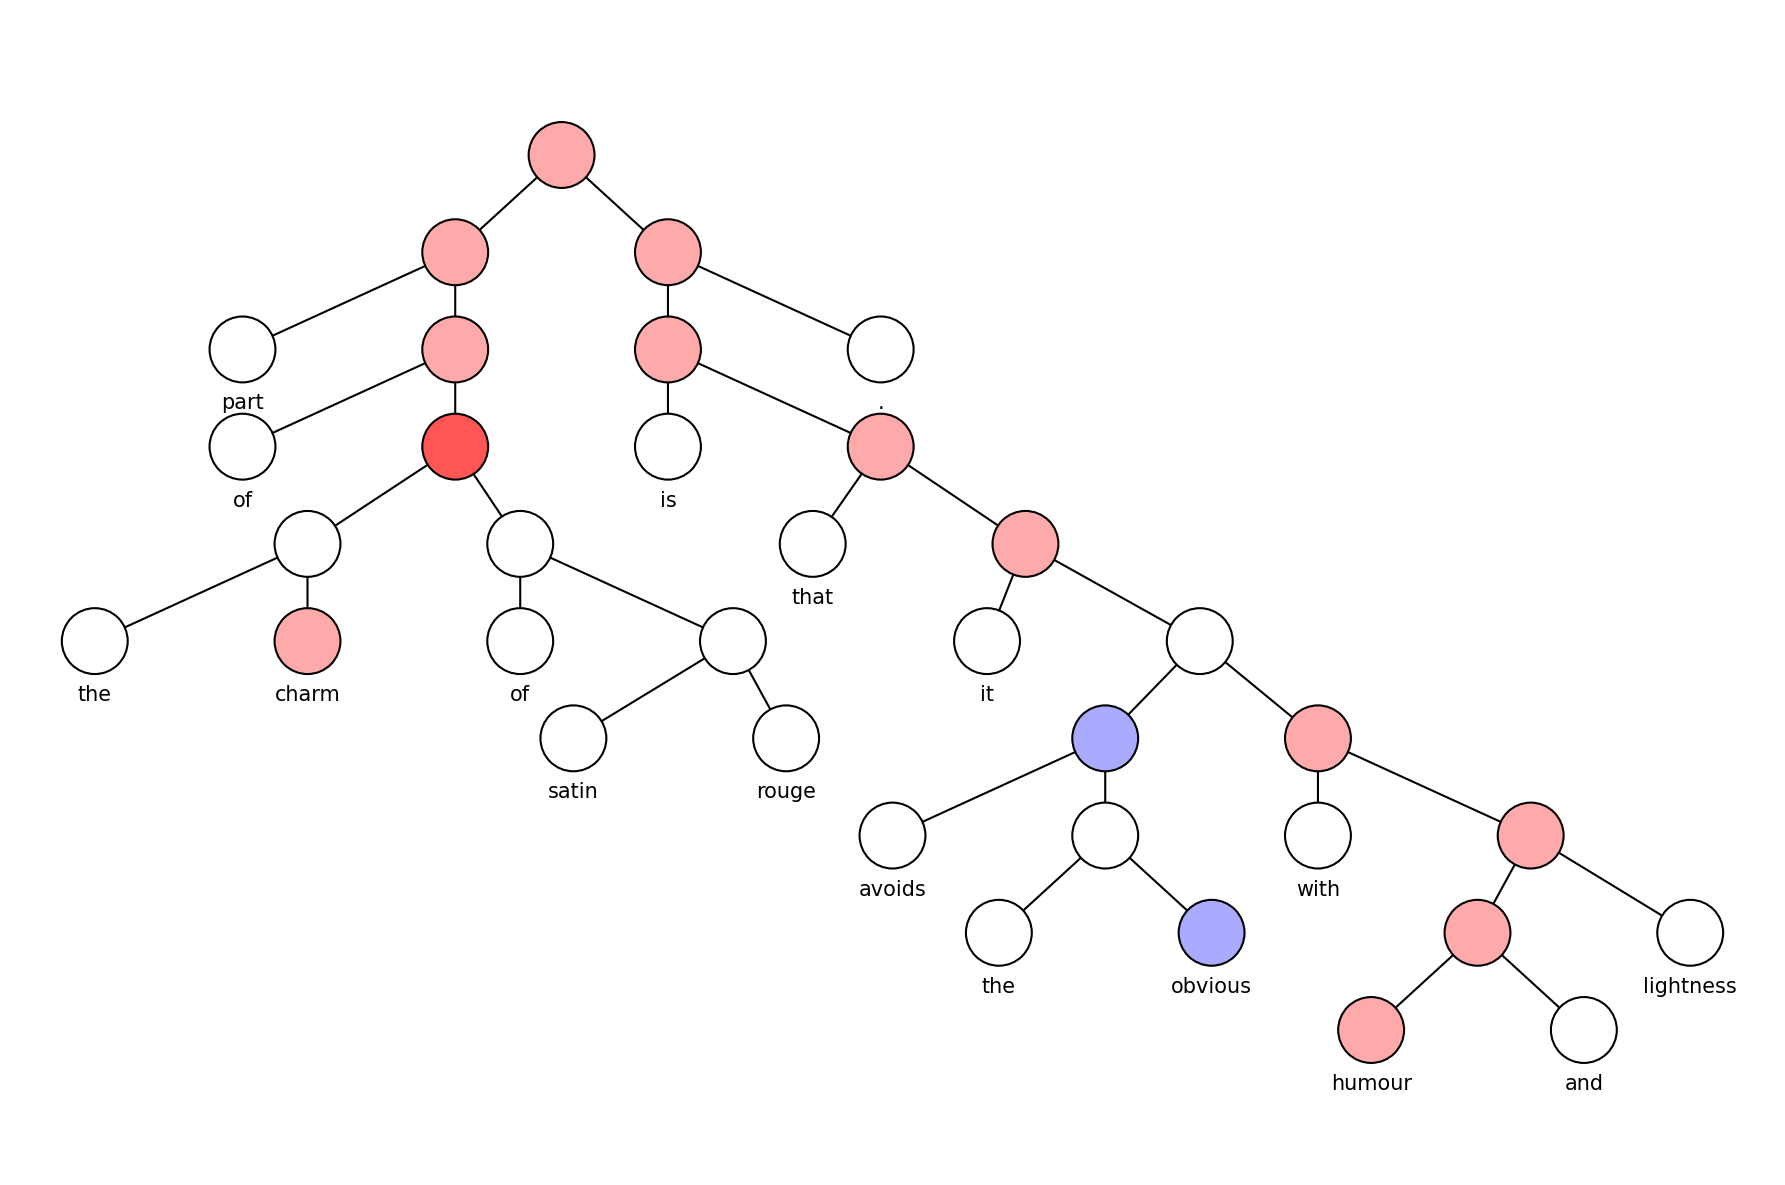

In [9]:
vis_tree_heat(tree, node_heat, vocab_words, node_labels=None, 
              save_dir=None,
              node_size=1000)

#### Plot $q=S \wedge \bar{S}$

To get the relevance scores for the query $q=S$, set the variable mode to Mode.OR (```mode = Mode.OR```).

{0: (185.0, 666.0), 1: (149.0, 594.0), 2: (77.0, 522.0), 3: (149.0, 522.0), 4: (77.0, 450.0), 5: (149.0, 450.0), 6: (99.0, 378.0), 7: (27.0, 306.0), 8: (99.0, 306.0), 9: (171.0, 378.0), 10: (171.0, 306.0), 11: (243.0, 306.0), 12: (189.0, 234.0), 13: (261.0, 234.0), 14: (221.0, 594.0), 15: (221.0, 522.0), 16: (221.0, 450.0), 17: (293.0, 450.0), 18: (270.0, 378.0), 19: (342.0, 378.0), 20: (329.0, 306.0), 21: (401.0, 306.0), 22: (369.0, 234.0), 23: (297.0, 162.0), 24: (369.0, 162.0), 25: (333.0, 90.0), 26: (405.0, 90.0), 27: (441.0, 234.0), 28: (441.0, 162.0), 29: (513.0, 162.0), 30: (495.0, 90.0), 31: (459.0, 18.0), 32: (531.0, 18.0), 33: (567.0, 90.0), 34: (293.0, 522.0)}


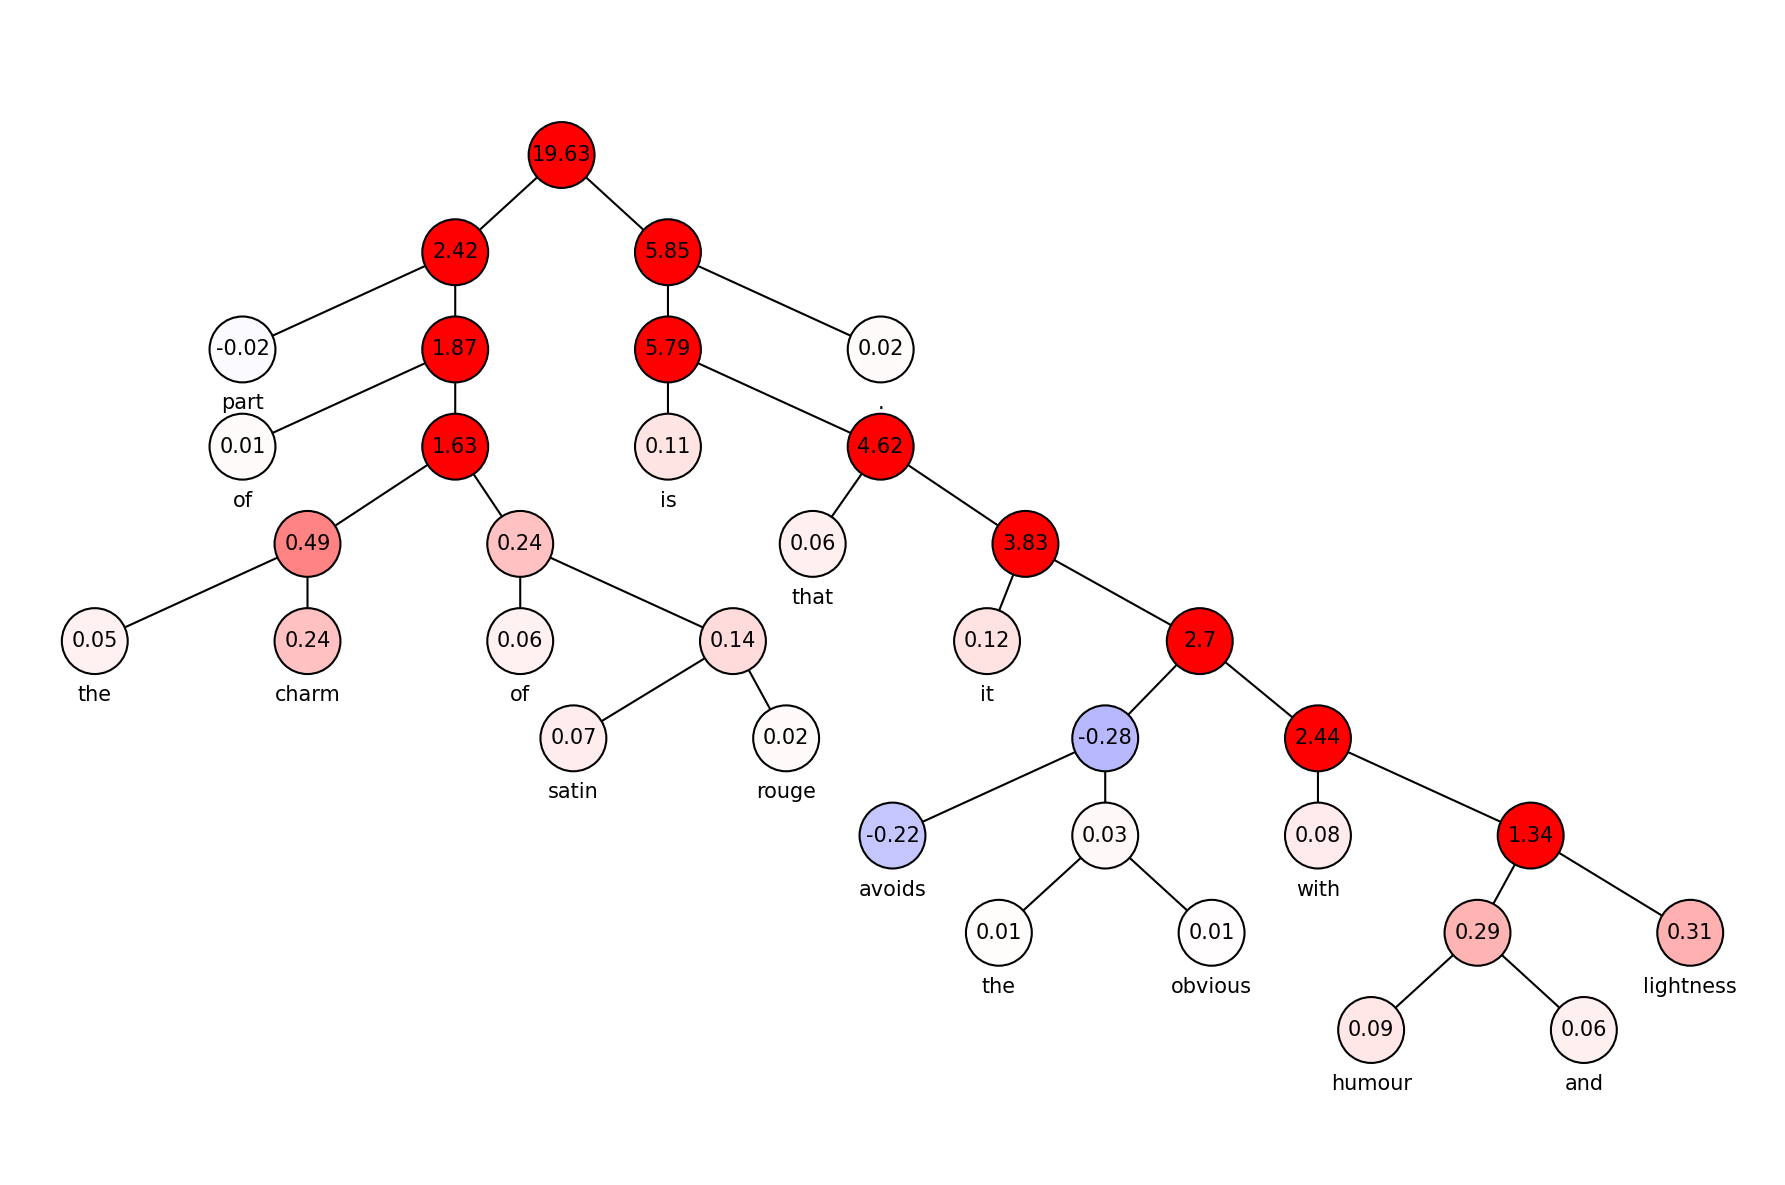

In [10]:
from enum import Enum

class Mode(Enum):
    OR = 0
    SUBSET = 1



mode = Mode.SUBSET
target = torch.tensor([-1, 1])
explainer = BERTSymbXAI(sample, target, model, pretrained_embeddings)


G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, words, lsent, verbose=False)
        
    if mode == Mode.OR:
        node_rels[node_id] = explainer.symb_or(token_set).item()
    if mode == Mode.SUBSET:
        node_rels[node_id] = explainer.subgraph_relevance(token_set).item()

    
node_heat = [make_color( rel, scaling=1) for rel in node_rels.values() ]
node_labels = {i:round(rel,2) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, 
              node_heat, 
              vocab_words,
              node_labels=node_labels,
              save_dir=None,
             node_size=1000)

## Analyse how the explanation method aligns with the human annotation

In [11]:
idrange = range(50) # idrange should be 200 to reproduce the paper's results.
modes = [Mode.OR, Mode.SUBSET]
verbose = True

all_contr_or = {i: [] for i in range(5)}
all_contr_sub = {i: [] for i in range(5)}

for sid in tqdm(idrange):
    tree = dataset[sid]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask']
    lsent =  [vocab_words[idw] for idw in input_ids[mask == 1]]
    sentence =  make_text_string(lsent)
    sample = tokenizer(sentence, return_tensors="pt")
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())

    

    target = torch.tensor([-1, 1])
    explainer = BERTSymbXAI(sample, target, model, pretrained_embeddings)

    G = dgl.to_networkx(tree)
    node_rels_or = {}
    node_rels_sub = {}

    try:
        for node_id in range(len(labels)):
            ances = nx.ancestors(G, node_id)
            ances.add(node_id)

            token_set = process_treeid2tokenid(ances, mask, words, lsent, verbose=False)

            if False:
                if cls_token_location not in token_set:
                    token_set.append(cls_token_location)  # always add CLS token
                if sep_token_location not in token_set:
                    token_set.append(sep_token_location)  # always add SEP token
            
            for mode in modes:
                if mode == Mode.OR:
                    node_rels_or[node_id] = explainer.symb_or(token_set).item()
                if mode == Mode.SUBSET:
                    node_rels_sub[node_id] = explainer.subgraph_relevance(token_set).item()
    except RuntimeError:
        if verbose: print(f'skip {sid}')
        continue
    node_labels = {i: int(label) for i,label in enumerate(labels)}
    
    assert len(node_labels.values()) == len(node_rels_or.values())
    assert len(node_labels.values()) == len(node_rels_sub.values())
    
    for label, rel in zip(node_labels.values(), node_rels_or.values()):
        all_contr_or[label].append(rel)
        
    for label, rel in zip(node_labels.values(), node_rels_sub.values()):
        all_contr_sub[label].append(rel)

 38%|████████████████▎                          | 19/50 [10:14<10:32, 20.41s/it]

skip 18


 60%|█████████████████████████▊                 | 30/50 [14:13<06:53, 20.67s/it]

skip 29


 82%|███████████████████████████████████▎       | 41/50 [21:17<06:28, 43.18s/it]

skip 40


100%|███████████████████████████████████████████| 50/50 [26:03<00:00, 31.27s/it]


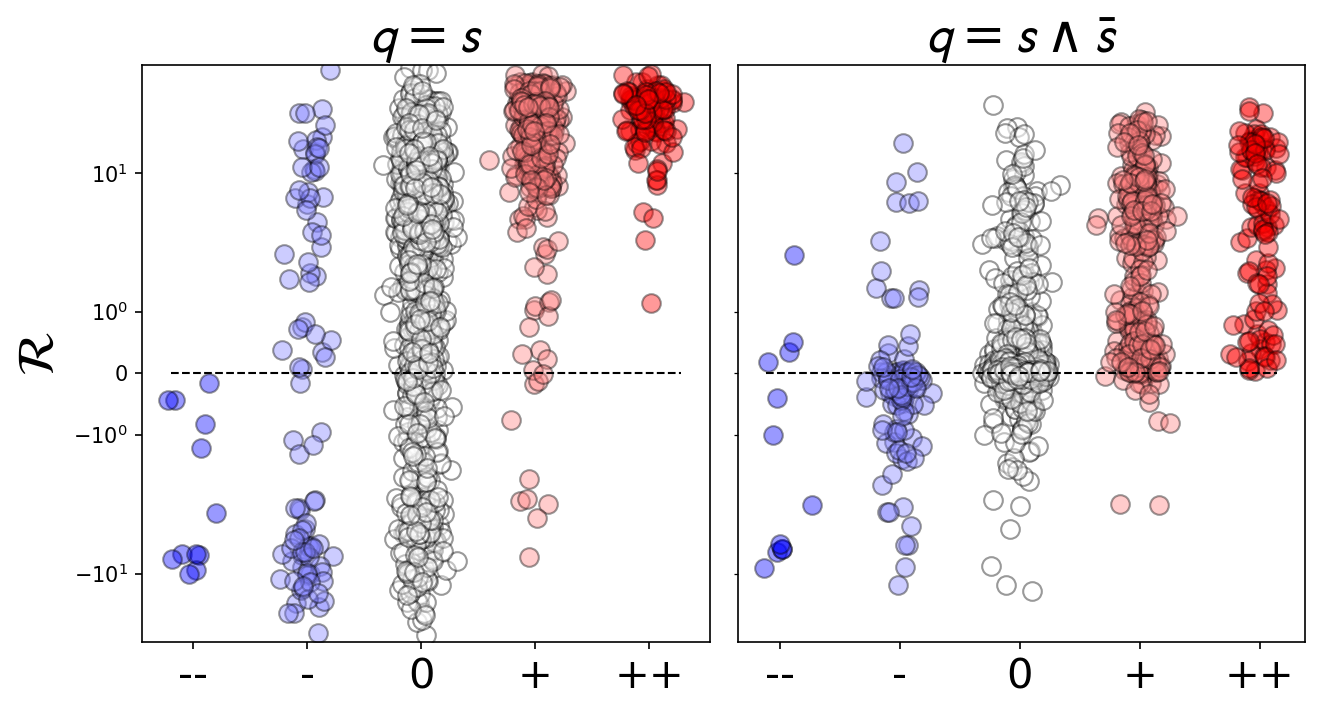

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
plt.rcParams.update({'font.size': 20})

for label, rels in all_contr_or.items():
    x = np.random.normal(loc=label, scale=.1, size=len(rels))
    axs[0].scatter(x,
                rels,
                alpha=.4, 
                edgecolors='black', 
                color=make_color(label-2, scaling=.5),
                s=80)
    
for label, rels in all_contr_sub.items():
    x = np.random.normal(loc=label, scale=.1, size=len(rels))
    axs[1].scatter(x,
                rels,
                alpha=.4, 
                edgecolors='black', 
                color=make_color(label-2, scaling=.5),
                s=80)
    
axs[0].axhline(y=0,xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
axs[0].set_xticks(list(label2sent_symb.keys()), list(label2sent_symb.values()), size=20)
axs[0].set_ylabel('$\\mathcal{R}$', size=25)
axs[0].set_yscale('symlog')
axs[0].set_title('$\\mathcal{q} = \\mathcal{s}$', size=25)

axs[1].axhline(y=0,xmin=0.05, xmax=.95, color='black', ls='--', linewidth=1)
axs[1].set_xticks(list(label2sent_symb.keys()), list(label2sent_symb.values()), size=20)
axs[1].set_yscale('symlog')
axs[1].set_title('$\\mathcal{q} = \\mathcal{s} \\wedge \\bar{\\mathcal{s}}$', size=25)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()